<img src="https://cdn-icons-png.flaticon.com/512/5988/5988246.png" style="float: left; margin: 20px; height: 85px">

# Regression Project
## Housing Value Prediction

--- 
# Part 1 - Exploratory Data Analysis

---

# Project Goal

<span style="font-size: 16px;"> The Ames housing market is the subject of study for a real estate investment firm seeking to identify undervalued properties with potential for investment and subsequent gains.
    <Br>This project's objective is to analyze the market dynamics of Ames to pinpoint opportunities for strategic investment. By identifying properties that are undervalued relative to their market potential, the firm aims to capitalize on opportunities for profitable real estate investments.

## Contents: 
- [<span style="font-size: 16px;"> Data Import & Cleaning](#Data-Import-and-Cleaning)
    - Null Values
- [<span style="font-size: 16px;"> Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - Category Features
    - Numerical Features
    - Target Distribution Form
    - Collinearity
- [<span style="font-size: 16px;"> Classes for Linear Model](#Classes-for-Linear-Model)

# Data Import & Cleaning

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [2]:
# reading data and standardizing columns
test = pd.read_csv('../datasets/test.csv')
test.columns = test.columns.str.lower().str.replace(' ','_')
train = pd.read_csv('../datasets/train.csv')
train.columns = train.columns.str.lower().str.replace(' ','_')

In [3]:
print('Train Dataset Shape: ',train.shape)
print('Train Dataset Duplicates: ', train.duplicated().sum())

Train Dataset Shape:  (2051, 81)
Train Dataset Duplicates:  0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

<span style="font-size: 16px;"> According to the dataset dictionary, id and pid are unique identifiers for the observations. Since the goal is to predict the price base on the house attributes, they will not be used by the model. Let's create a list with these two columns to remove.

In [5]:
to_remove = ['id', 'pid']

### Null Values

In [6]:
null_columns = train.columns[train.isna().any()].tolist()
print(train[null_columns].isna().sum().sort_values(ascending = True))

total_bsmt_sf        1
garage_area          1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
bsmt_full_bath       2
bsmt_half_bath       2
mas_vnr_area        22
mas_vnr_type        22
bsmtfin_type_1      55
bsmt_qual           55
bsmt_cond           55
bsmtfin_type_2      56
bsmt_exposure       58
garage_type        113
garage_finish      114
garage_qual        114
garage_cond        114
garage_yr_blt      114
lot_frontage       330
fireplace_qu      1000
fence             1651
alley             1911
misc_feature      1986
pool_qc           2042
dtype: int64


<span style="font-size: 16px;">
    There are features where most (>1025) of the observations do not have a value. Let's see how many have more than 95% of observations like this.

In [7]:
# Calculate the percentage of null values for each feature
null_percentages = (train.isnull().sum() / train.shape[0]) * 100

# Filter features with more than 95% null values
high_null_features = null_percentages[null_percentages > 95].index.tolist()

print("Features with more than 95% null values:", high_null_features)

Features with more than 95% null values: ['pool_qc', 'misc_feature']


<span style="font-size: 16px;">
A feature does not have much variability if 95% or more of the observations present one unique value, and this does not translate into variability in the response variable. In the context of linear regression, it does not provide useful information for predicting the target. Those features that do not present value in more than 95% of the observations will be removed from the model.

In [8]:
# Adding those null features to the list of columns to remove
to_remove += high_null_features

# Exploratory Data Analysis

## Category Features

<span style="font-size: 16px;"> One thing to check about category features is if any of them present high concentration in the categories, which do not translate into variability of the response.
<br>
Let's see if there are features where one category concentrate more than 95% of the observations in the dataset.

In [9]:
high_concentration_features = []

for column in train.columns:
    # Calculate the percentage of occurrences for each category
    category_percentages = train[column].value_counts(normalize=True) * 100
    # Check if the maximum percentage is greater than 95%
    if category_percentages.max() > 95:
        high_concentration_features.append(column)

print("Features with categories that concentrate more than 95% of the observations:", high_concentration_features)

Features with categories that concentrate more than 95% of the observations: ['street', 'utilities', 'land_slope', 'condition_2', 'roof_matl', 'heating', 'low_qual_fin_sf', 'kitchen_abvgr', 'garage_cond', '3ssn_porch', 'pool_area', 'misc_val']


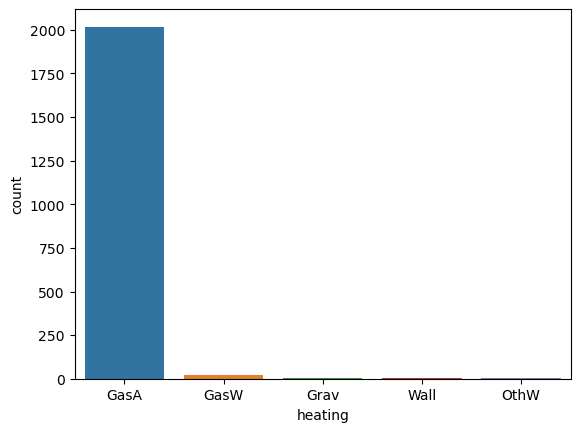

In [10]:
sns.countplot(data = train, x = 'heating');

<span style="font-size: 16px;"> A feature does not have much variability if 95% or more of the observations belongs to one class only. In the context of linear regression, it does not provide useful information for predicting the target variable.

In [11]:
# Adding the high concentration features to the list of features to remove from the model
to_remove += high_concentration_features

## Numeric Features

In [12]:
train_columns = list(train.columns)
train_columns = list(set(train_columns)-set(to_remove))
train_eda = train[train_columns].copy()
numerics = list(train_eda.select_dtypes(include=['float64', 'int64']).columns)
numerics.remove('saleprice')
print(f'Number of columns kept: ', len(train_columns))
print('Numerical columns: ',numerics)

Number of columns kept:  65
Numerical columns:  ['total_bsmt_sf', 'garage_cars', 'fireplaces', 'year_remod/add', 'half_bath', 'lot_area', 'gr_liv_area', 'enclosed_porch', 'yr_sold', 'bsmt_half_bath', 'year_built', 'mas_vnr_area', 'bsmt_unf_sf', 'lot_frontage', 'bsmtfin_sf_1', 'mo_sold', '2nd_flr_sf', 'full_bath', 'wood_deck_sf', 'overall_qual', 'bedroom_abvgr', 'garage_yr_blt', 'open_porch_sf', 'screen_porch', 'bsmt_full_bath', 'bsmtfin_sf_2', 'overall_cond', 'ms_subclass', 'garage_area', '1st_flr_sf', 'totrms_abvgrd']


In [13]:
train_eda[numerics].head()

,total_bsmt_sf,garage_cars,fireplaces,year_remod/add,half_bath,lot_area,gr_liv_area,enclosed_porch,yr_sold,bsmt_half_bath,...,garage_yr_blt,open_porch_sf,screen_porch,bsmt_full_bath,bsmtfin_sf_2,overall_cond,ms_subclass,garage_area,1st_flr_sf,totrms_abvgrd
0,725.0,2.0,0,2005,1,13517,1479,0,2010,0.0,...,1976.0,44,0,0.0,0.0,8,60,475.0,725,6
1,913.0,2.0,1,1997,1,11492,2122,0,2009,0.0,...,1997.0,74,0,1.0,0.0,5,60,559.0,913,8
2,1057.0,1.0,0,2007,0,7922,1057,0,2010,0.0,...,1953.0,52,0,1.0,0.0,7,20,246.0,1057,5
3,384.0,2.0,0,2007,1,9802,1444,0,2010,0.0,...,2007.0,0,0,0.0,0.0,5,60,400.0,744,7
4,676.0,2.0,0,1993,0,14235,1445,0,2010,0.0,...,1957.0,59,0,0.0,0.0,8,50,484.0,831,6


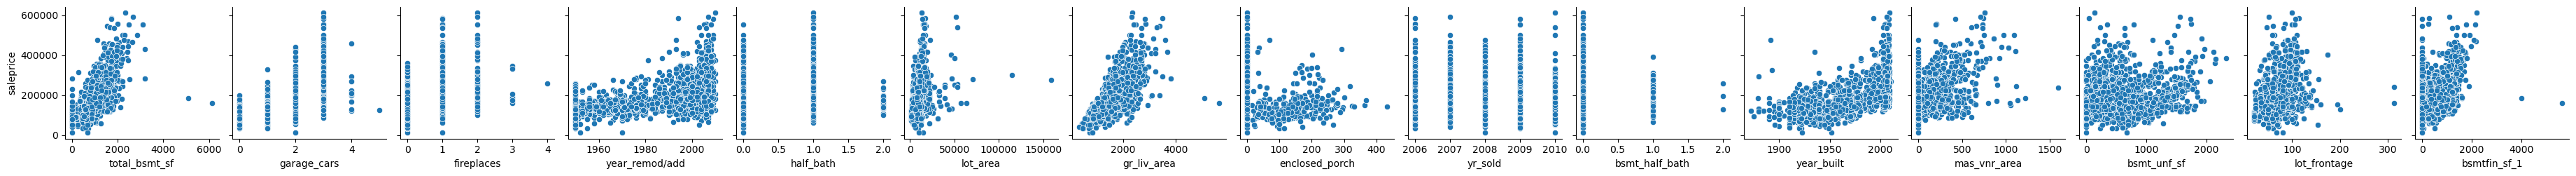

In [14]:
sns.pairplot(data = train_eda, x_vars = numerics[:15], y_vars = 'saleprice')
plt.show();

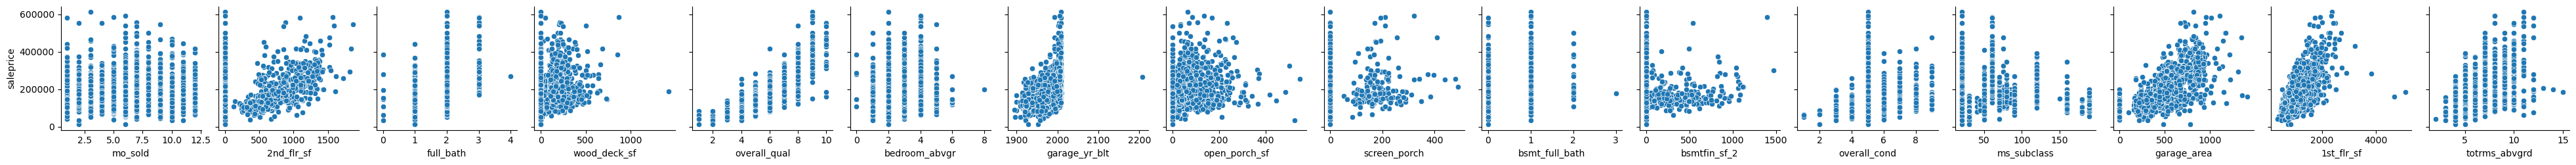

In [15]:
sns.pairplot(data = train_eda, x_vars = numerics[15:], y_vars = 'saleprice')
plt.show();

<br><br><span style="font-size: 16px;"> Two features, ```ms_subclass``` and ```mo_sold```, have numerical values but are better suited to be treated as categorical features in our analysis. This is because the values in these columns do not represent a hierarchical relationship or convey quantitative information in the context of our analysis. To reflect their categorical nature more accurately, we will change the data types of these columns to 'category' within the train class definition.

In [16]:
cat_features = ['ms_subclass', 'mo_sold']
numerics = list(set(numerics) - set(cat_features))

<span style="font-size: 20px;"> - Outliers <br> </span>
<span style="font-size: 16px;"> It is possible to see some outliers in these numerical features. <br>
While modelling, I will test if removing these outliers can improve the model.

In [17]:
# dictionary with outliers features and the respective values the outliers exceed
outliers_features = {'gr_liv_area': 4000, 'bsmtfin_sf_1': 3000, 'wood_deck_sf': 1000, '1st_flr_sf': 4000, \
                     'lot_frontage': 250, 'lot_area':100000, 'total_bsmt_sf': 4000}

In [18]:
test_outliers = train.copy()

for feature, threshold in outliers_features.items():
    mask = (test_outliers[feature] <= threshold) | (test_outliers[feature].isnull())
    test_outliers = test_outliers[mask]

print(test_outliers.shape)

(2045, 81)


In [19]:
print('Number of observations removed after removing outliers: {}'.format(train.shape[0] - test_outliers.shape[0]))

Number of observations removed after removing outliers: 6


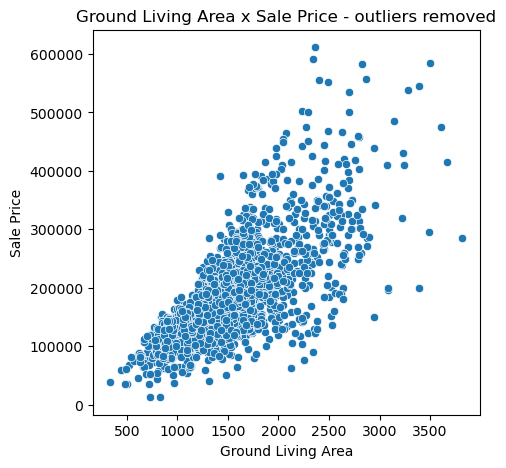

In [20]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=test_outliers, x='gr_liv_area', y='saleprice')
plt.xlabel('Ground Living Area')
plt.ylabel('Sale Price')
plt.title('Ground Living Area x Sale Price - outliers removed')
plt.show()

<span style="font-size: 20px;"> - Features with many zeros <br> </span>
<span style="font-size: 16px;">It is possible to see also that some features have zeros that do not help to see the relationship of the presence of that feature with the target.

In [21]:
# features with many zeros
zero_features = ['garage_area','bsmtfin_sf_1', 'bsmtfin_sf_2', 'enclosed_porch', 'open_porch_sf', 'wood_deck_sf', \
                 'mas_vnr_area', 'screen_porch', 'total_bsmt_sf', 'bsmt_unf_sf', '2nd_flr_sf']

for column in zero_features:
    print("Percentage of observations {} = 0: \n {:.3}".format(column, (train[column] == 0).mean() * 100))

Percentage of observations garage_area = 0: 
 5.51
Percentage of observations bsmtfin_sf_1 = 0: 
 32.0
Percentage of observations bsmtfin_sf_2 = 0: 
 87.9
Percentage of observations enclosed_porch = 0: 
 84.1
Percentage of observations open_porch_sf = 0: 
 44.5
Percentage of observations wood_deck_sf = 0: 
 52.4
Percentage of observations mas_vnr_area = 0: 
 59.3
Percentage of observations screen_porch = 0: 
 91.2
Percentage of observations total_bsmt_sf = 0: 
 2.63
Percentage of observations bsmt_unf_sf = 0: 
 8.04
Percentage of observations 2nd_flr_sf = 0: 
 58.1


<span style="font-size: 16px;">
Since there are some features with lots of zeros, in the context of linear regression, this also might not translate into variability of the response variable.<br><br>
For the features with more than 30% of the observations with zero as value, I will test if replacing them with the mean value of the column can improve the model.

In [22]:
testing_zero = train.copy()
zero_features = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'enclosed_porch', 'open_porch_sf', 'wood_deck_sf', \
                 'mas_vnr_area', 'screen_porch', '2nd_flr_sf']

for feature in zero_features:
    mask = testing_zero[feature] == 0
    testing_zero.loc[mask, feature] = np.nan
    testing_zero.loc[mask, feature] = testing_zero[feature].mean()
    
# features with many zeros
zero_features = ['garage_area','bsmtfin_sf_1', 'bsmtfin_sf_2', 'enclosed_porch', 'open_porch_sf', 'wood_deck_sf', \
                 'mas_vnr_area', 'screen_porch', 'total_bsmt_sf', 'bsmt_unf_sf', '2nd_flr_sf']

for column in zero_features:
    print("Percentage of observations {} = 0: \n {:.3}".format(column, (testing_zero[column] == 0).mean() * 100))

Percentage of observations garage_area = 0: 
 5.51
Percentage of observations bsmtfin_sf_1 = 0: 
 0.0
Percentage of observations bsmtfin_sf_2 = 0: 
 0.0
Percentage of observations enclosed_porch = 0: 
 0.0
Percentage of observations open_porch_sf = 0: 
 0.0
Percentage of observations wood_deck_sf = 0: 
 0.0
Percentage of observations mas_vnr_area = 0: 
 0.0
Percentage of observations screen_porch = 0: 
 0.0
Percentage of observations total_bsmt_sf = 0: 
 2.63
Percentage of observations bsmt_unf_sf = 0: 
 8.04
Percentage of observations 2nd_flr_sf = 0: 
 0.0


## Target distribution form

<span style="font-size: 16px;"> In the context of linear regression, a target with normal distribution suits better for the model. Let's check how is this target distributed.

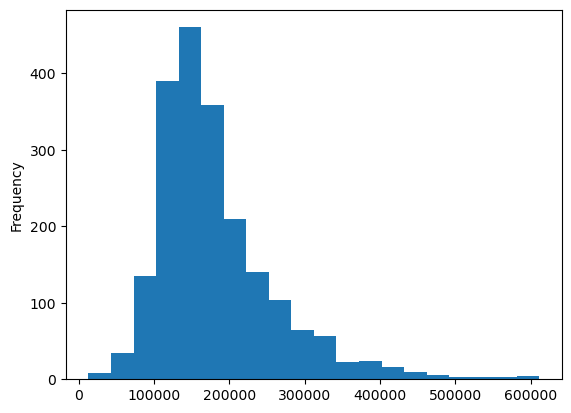

In [23]:
train['saleprice'].plot(kind='hist', bins=20);

<span style="font-size: 16px;"> It looks like a transformation of this target, leading to a more normal distribution, could help the model.

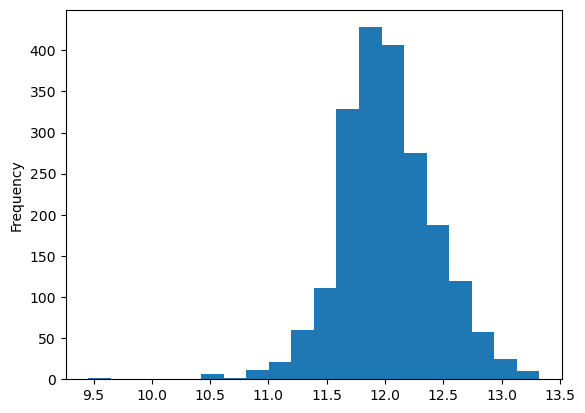

In [24]:
np.log(train['saleprice']).plot(kind='hist', bins=20);

<span style="font-size: 16px;"> The graph above presents distribution which is more similar to the normal distribution. Log Transformation of the target variable will be applied in the model.

## Collinearity

<span style="font-size: 16px;"> Variables with collinearity can lead to variance in the model, let's check if there is any in the numerical features of the dataset. First, I will filter variables with high correlation and then check the variance inflation factor (VIF).

In [25]:
print(numerics)

['year_built', '2nd_flr_sf', 'total_bsmt_sf', 'full_bath', 'wood_deck_sf', 'bsmt_full_bath', 'garage_cars', 'bsmtfin_sf_2', 'fireplaces', 'overall_qual', 'year_remod/add', 'mas_vnr_area', 'overall_cond', 'half_bath', 'bedroom_abvgr', 'bsmt_unf_sf', 'gr_liv_area', 'lot_area', 'screen_porch', 'enclosed_porch', 'yr_sold', 'garage_yr_blt', 'open_porch_sf', 'lot_frontage', 'bsmtfin_sf_1', 'bsmt_half_bath', 'garage_area', '1st_flr_sf', 'totrms_abvgrd']


<span style="font-size: 16px;">
    Because it is necessary to fill null values for the heat map of the correlation, let's create a dataframe from train and fill the null values using the mean of the features. While modelling, different methods for filling null values will be tested.

In [26]:
for_correlation = train.copy()

# Filling null values in numerical columns to create correlation heatmap
for numeric in numerics:
    if for_correlation[numeric].isna().sum()!= 0:
        for_correlation.loc[for_correlation[numeric].isna(), numeric] = for_correlation[numeric].mean()

<span style="font-size: 16px;">Since the main interest is on variables with high correlation (I considered >50%), I will filter the heatmap to show these variables.

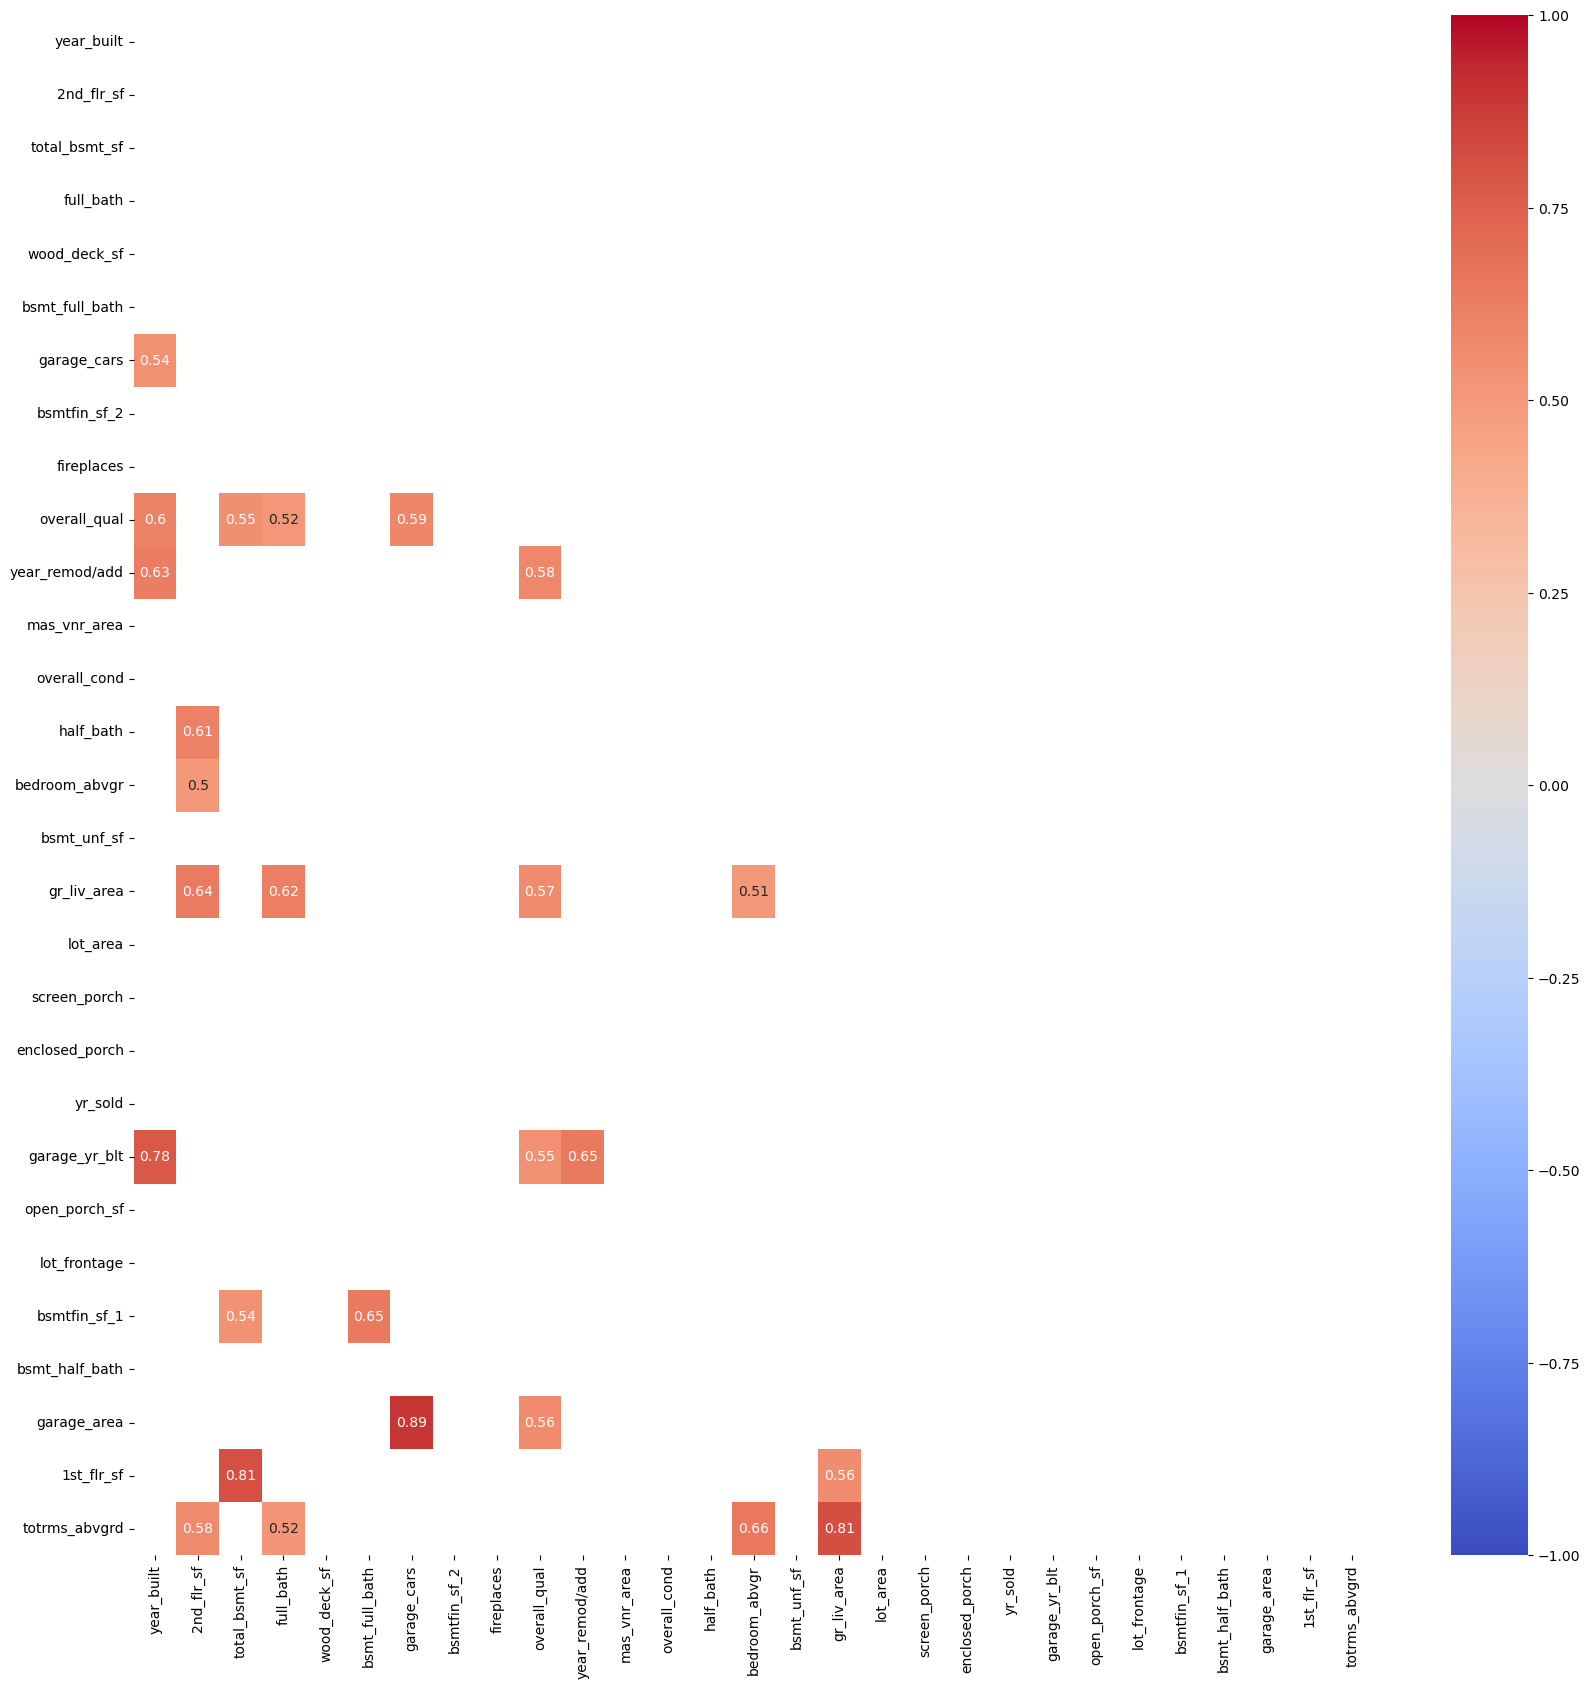

In [27]:
# Compute correlation matrix
corr_matrix = for_correlation[numerics].corr()

# Filter correlations greater than or equal to 0.50
strong_correlations = corr_matrix[corr_matrix >= 0.5]

# Create a mask for the filtered correlations
mask = np.triu(np.ones_like(strong_correlations, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(strong_correlations, mask=mask, cmap='coolwarm',
            vmin=-1, vmax=1, annot=True)
plt.show()

In [28]:
high_correlation = ['overall_qual', 'totrms_abvgrd', 'garage_cars', 'bsmtfin_sf_1', 'year_remod/add', 'garage_yr_blt', 'gr_liv_area',
'year_built', 'total_bsmt_sf', 'garage_area', '2nd_flr_sf']

<span style="font-size: 16px;"> Let's now check if variance inflation factor with these variables show us if there are multicollinearity in this dataset.

In [29]:
for_vif = for_correlation[high_correlation]

vals = [VIF(for_vif, i)
for i in range(1, for_vif.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=for_vif.columns[1:]) 
vif

,vif
totrms_abvgrd,57.234023
garage_cars,35.900109
bsmtfin_sf_1,2.869217
year_remod/add,11778.451326
garage_yr_blt,17671.862869
gr_liv_area,71.616574
year_built,13720.925969
total_bsmt_sf,23.503973
garage_area,32.772450
2nd_flr_sf,6.152089


<span style="font-size: 16px;"> VIF values for  ```year_remod/add```, ```garage_yr_blt``` and ```year_built``` are very high, indicating a multicollinearity between the three. <br>
I will keep only one of them, the one with the highest correlation with the target.

In [30]:
train[['year_remod/add', 'year_built', 'garage_yr_blt', 'saleprice']].corr()

,year_remod/add,year_built,garage_yr_blt,saleprice
year_remod/add,1.000000,0.629116,0.674024,0.550370
year_built,0.629116,1.000000,0.825316,0.571849
garage_yr_blt,0.674024,0.825316,1.000000,0.533922
saleprice,0.550370,0.571849,0.533922,1.000000


In [31]:
# removing features with multicollinearity
to_remove += ['year_remod/add', 'garage_yr_blt']

<span style="font-size: 16px;">Now, let's create some classes applying the transformations suggested along this notebook and later see how which one performs best in the linear model.

# Classes for Linear Model

<span style="font-size: 16px;">
Let's define classes to transform datasets into different train dataset forms to see what is best for the model. Input datasets will be modified as described below:
<br><br>
<span style="font-size: 16px;">
(1) Standardizing columns
<br><br>
(2) Standardizing and filtering columns (using 'to_remove' list)
<br><br>
(3) 2 + removing the outliers in the features columns
<br><br>
(4) 2 + changing 0 values in the features columns
<br><br>
    
<span style="font-size: 17px;"> Then, I will fit these different X's into the linear model and see what is best.

In [32]:
class Original():
    def __init__(self):
        
        # numericals that are actually category features
        self.cat_features = ['ms_subclass', 'mo_sold']
        
        # to filter columns when the class is called
        self.train_columns = ['land_contour', 'bsmt_qual', 'bsmtfin_sf_2', 'screen_porch', 'lot_area', 'overall_qual',\
                          'full_bath', 'totrms_abvgrd', 'mo_sold', 'exter_cond', 'ms_subclass', 'heating_qc',\
                          '1st_flr_sf', 'bsmtfin_type_2', 'neighborhood', 'kitchen_qual', 'exterior_2nd',\
                          'central_air', 'garage_qual', 'garage_type', 'half_bath', 'bldg_type', 'lot_config',\
                          'functional', 'exterior_1st', 'garage_cars', 'exter_qual', 'open_porch_sf',\
                          'bsmt_exposure', 'alley', 'electrical', 'bedroom_abvgr', 'bsmt_full_bath',\
                          'condition_1', '2nd_flr_sf', 'fence', 'garage_area', 'mas_vnr_type', 'fireplace_qu',\
                          'overall_cond', 'bsmt_cond', 'enclosed_porch', 'bsmt_half_bath', 'ms_zoning',\
                          'fireplaces', 'paved_drive', 'bsmtfin_type_1', 'foundation', 'roof_style',\
                          'garage_finish', 'lot_frontage', 'lot_shape', 'bsmt_unf_sf', 'year_built',\
                          'bsmtfin_sf_1', 'gr_liv_area', 'sale_type', 'house_style', 'mas_vnr_area',\
                          'total_bsmt_sf', 'wood_deck_sf', 'yr_sold', 'saleprice']
        
        # to filter columns when the class is called
        self.x_columns = ['land_contour', 'bsmt_qual', 'bsmtfin_sf_2', 'screen_porch', 'lot_area', 'overall_qual',\
                          'full_bath', 'totrms_abvgrd', 'mo_sold', 'exter_cond', 'ms_subclass', 'heating_qc',\
                          '1st_flr_sf', 'bsmtfin_type_2', 'neighborhood', 'kitchen_qual', 'exterior_2nd',\
                          'central_air', 'garage_qual', 'garage_type', 'half_bath', 'bldg_type', 'lot_config',\
                          'functional', 'exterior_1st', 'garage_cars', 'exter_qual', 'open_porch_sf',\
                          'bsmt_exposure', 'alley', 'electrical', 'bedroom_abvgr', 'bsmt_full_bath',\
                          'condition_1', '2nd_flr_sf', 'fence', 'garage_area', 'mas_vnr_type', 'fireplace_qu',\
                          'overall_cond', 'bsmt_cond', 'enclosed_porch', 'bsmt_half_bath', 'ms_zoning',\
                          'fireplaces', 'paved_drive', 'bsmtfin_type_1', 'foundation', 'roof_style',\
                          'garage_finish', 'lot_frontage', 'lot_shape', 'bsmt_unf_sf', 'year_built',\
                          'bsmtfin_sf_1', 'gr_liv_area', 'sale_type', 'house_style', 'mas_vnr_area',\
                          'total_bsmt_sf', 'wood_deck_sf', 'yr_sold']        
        
        
        # features that will have outliers removed
        self.outliers_features = {'gr_liv_area': 4000, 'bsmtfin_sf_1': 3000, 'wood_deck_sf': 1000,\
                                   '1st_flr_sf': 3500, 'lot_frontage': 250, 'lot_area':100000,\
                                   'total_bsmt_sf': 4000}

        
        # features that have more than 10% of observations with zero
        self.zero_features = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'enclosed_porch', 'open_porch_sf', 'wood_deck_sf', \
                              'mas_vnr_area', 'screen_porch', '2nd_flr_sf'] 

    
    def zeros(self, dataset):
        for feature in self.zero_features:
            mask = dataset[feature] == 0
            dataset.loc[mask, feature] = np.nan
            dataset.loc[mask, feature] = dataset[feature].mean()
        return dataset
    
    
    def outliers(self, dataset):
        for feature, threshold in self.outliers_features.items():
            mask = (dataset[feature] <= threshold) | (dataset[feature].isnull())
            dataset = dataset[mask]
        return dataset
    
    
    def __call__(self, dataset):
        df = dataset.copy()
        #standardizing columns names
        df.columns = df.columns.str.lower().str.replace(' ','_')
        df[self.cat_features] = df[self.cat_features].astype('category')
        if ['id', 'pid'] in list(df.columns):
            df = df.drop(['id', 'pid'], axis=1)
        return df

In [33]:
class Train_Columns(Original):
    def __call__(self, dataset):
        df = super().__call__(dataset)
        df = df[self.train_columns]
        return df

In [34]:
class Train_Outliers(Train_Columns):
    def __call__(self, dataset):
        df = super().__call__(dataset)
        df = self.outliers(df)
        return df

In [35]:
class Train_Zeros(Train_Columns):
    def __call__(self, dataset):
        df = super().__call__(dataset)
        df = self.zeros(df)
        return df

In [36]:
class X_Columns(Original):
    def __call__(self, dataset):
        df = super().__call__(dataset)
        df = df[self.x_columns]
        df = self.outliers(df)
        return df